In [ ]:
!pip install ipyplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.8 MB/s eta 0:00:00


## Setup the Google Colab

In [ ]:
import os
from pathlib import Path
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import ipyplot


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `force_b64` param to `True`.
        


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##%env DATA_DIRECTORY = C:\Workspace\Practice\Python\LeraningWorkspace\data

In [ ]:
%env DATA_DIRECTORY = /content/drive/MyDrive/Task-3-Data Augmentation/data
%env TEST_DATA_DIRECTORY = /content/drive/MyDrive/Task-4-Model(s) Building/data

env: DATA_DIRECTORY=/content/drive/MyDrive/Task-3-Data Augmentation/data
env: TEST_DATA_DIRECTORY=/content/drive/MyDrive/Task-4-Model(s) Building/data


In [ ]:
directory = os.environ.get("DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/drive/MyDrive/Task-3-Data Augmentation/data


## Add some utility functions here

In [ ]:
## Code to clean kaggle output folders
def remove_folder_contents(folder, recurse=False):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                if recurse is True:
                    remove_folder_contents(file_path)
                    os.rmdir(file_path)
                continue
        except Exception as e:
            print(e)

In [ ]:
def checkPathExists(path):
  if not os.path.exists(path):
    print(f"Cannot access path: {path}")
  else:
    print (f"Path {path} accessible")

In [ ]:
def buildCropDiseaseCountTuple(instanceFolder):
    # Name of Crop and Disease is the folder name so split it . Need to change the logic here based on the data source . Much Pain!!
    # Count will be just samples within the folder
    str_name = str(instanceFolder.name)
    str_name = str_name.replace(" leaf", "").rstrip()
    print(str_name)
    values = str_name.split(" ", 2)
    f = instanceFolder.rglob('*')
    counts = np.unique([x.parent for x in f], return_counts=True)[1]
    if len(values) == 1:
        values = ['Coffee', values[0]]
        #values.append('healthy')
    return (values[0], values[1], counts[0].tolist())

In [ ]:
def readFolderAndSaveDataFrame(DataFolder, classNames=None):
    '''
    Read the folder - Note the assumption here is that the images are already seperated into their respective class subfolders
    Example -
        <root>
            - <class 1>
                - <image 1>
                - <image 2>
            - <class 2>
                - <image 1>
                - <image 2>
    '''
    dataFolder = Path(f"{DataFolder}")
    dataList = []
    # Get all the folders within the path - The list of folders are the classes.
    if classNames != None:
        instancePathList = [f for f in dataFolder.iterdir() if f.is_dir() and f.name in classNames]
    else:
        instancePathList = [f for f in dataFolder.iterdir() if f.is_dir()]
    for classPath in instancePathList:
        dataList.append(buildCropDiseaseCountTuple(classPath))

    ## Make a DataFrame
    samplesDataFrame = pd.DataFrame(dataList, columns=['Crop', 'Disease', 'numberImages'])
    return samplesDataFrame

In [ ]:
def generate_pie_plot(df, title="Categories", ax = None):
    proportions = []
    sz = len(df.Disease.unique())
    total = np.sum(df.numberImages)
    for c in range(sz):
        prop = df.numberImages[c]
        print(f"Proportion of data in class {df.Disease[c]} is {prop} : {prop/total*100:0.2f} %")
        proportions.append(prop)

    #colors = ['#003f5c', '#58508d' , '#bc5090', '#ff6361', '#ffa600']
    colors = ['gray', '#f8af3a', '#544ED5', '#71a2a5', '#bc5090']

    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(proportions, labels=df.Disease, autopct='%1.1f%%', colors = colors, textprops={'color':"black"})
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(title, color='black')

In [ ]:
def saveImageDataAndMetaData(dataDir, outputDir, classNames, outputfilename):
    metadata_tuplelist = []
    if classNames != None:
      class_list = [x for x in dataDir.iterdir() if x.name in classNames]
    else:
      class_list = [x for x in dataDir.iterdir()]
    for c, class_ in enumerate(class_list):
        print(f"Tracking {class_}")
        for f, file in enumerate(class_.glob(f"*")):
            im = cv2.imread(str(file))
            h, w, ch = im.shape
            metadata_tuplelist.append((f"{file}", class_.name, h, w, ch))
    print(len(metadata_tuplelist))
    metadata_df = pd.DataFrame(metadata_tuplelist, columns=['FileName', 'ClassName', 'FrameHeight', 'FrameWidth', 'Channels'])
    print(metadata_df.shape)
    metadata_df.to_csv(outputDir.joinpath(outputfilename))

In [ ]:
## Load all the images and the keypoints
def LoadData(inputDir, imageSize):
    all_images = []
    all_classes = []
    all_ids = []
    for j, p in enumerate(inputDir.glob(f"*.csv")):
        df = pd.read_csv(p)
        sz = df.shape[0]
        for i in range(sz):
            file = df.iloc[i]['FileName']
            #img = cv2.imread(str(inputDir.joinpath(file)))
            #plt.imshow(img)
            #plt.show()
            all_classes.append(df.iloc[i]['ClassName'])
            #img = cv2.resize(img, (imageSize, imageSize))
            all_images.append(file)
            all_ids.append(file.split('.')[0])
    print(len(all_images))
    all_images = np.asarray(all_images)
    all_classes = np.asarray(all_classes)
    all_ids = np.asarray(all_ids)
    return all_images, all_classes, all_ids

In [ ]:
def resize_image(input_folder, output_folder):
  for c in CLASSNAMES:
    folder_path = Path(input_folder)/c
    output_path = Path(output_folder)/c
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"Track {c}")
    for image_path in folder_path.glob('*'):
      #print(image_path)
      img = cv2.imread(str(image_path))
      #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, [256, 256])
      cv2.imwrite(str(output_path/image_path.name), img)
      #print(output_path/image_path.name)
  return

In [ ]:
import imutils
def rotate_image(input_folder, output_folder):
  for c in CLASSNAMES:
    folder_path = Path(input_folder)/c
    output_path = Path(output_folder)/c
    output_path.mkdir(parents=True, exist_ok=True)
    print(f"Track {c}")
    for image_path in folder_path.glob('*'):
      #print(image_path)
      img = cv2.imread(str(image_path))
      #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      for angle in np.arange(0, 360, 90):
        rotated = imutils.rotate_bound(img, angle)
        opfile = output_path.joinpath(f"Aug_rot_{angle}_{image_path.name}")
        cv2.imwrite(str(opfile), rotated)
        #break

  return

In [ ]:
import ipyplot
def VisualizeAsClassTabs(csvFile, classNames, size):
  df = pd.read_csv(csvFile)
  inputDir = csvFile.parent
  image_array = []
  label_array = []
  for c in CLASSNAMES:
    cdf = df.query(f'ClassName == "{c}"')
    for i in np.random.choice(np.arange(0, cdf.shape[0]), size=(size,)):
      file = cdf.iloc[i]['FileName']
      img = cv2.imread(str(inputDir.joinpath(file)))
      label_array.append(cdf.iloc[i]['ClassName'])
      image_array.append(img)

  ipyplot.plot_class_tabs(image_array, label_array, max_imgs_per_tab = size, img_width=150)


## Get the coffee dataset

In [ ]:
directory = os.environ.get("DATA_DIRECTORY")
ROOT_DIR = Path(tempfile.mkdtemp()) if directory is None else Path(directory)
print(ROOT_DIR)

/content/drive/MyDrive/Task-3-Data Augmentation/data


In [ ]:
CLASSNAMES = ['Healthy', 'Cescospora', 'Miner', 'Phoma', 'Rust']

In [ ]:
SINGLE_LEAVES_DATA_DIR_TRAIN = Path(root_dir).joinpath('002_strategy_just_single_leaves/train_opencv_resized')

In [ ]:
testDirectory = os.environ.get("TEST_DATA_DIRECTORY")
SINGLE_LEAVES_DATA_DIR_TEST = Path(testDirectory).joinpath('000_test_and_val_dataset_opencv_resized')

In [ ]:
checkPathExists(SINGLE_LEAVES_DATA_DIR_TEST)
checkPathExists(SINGLE_LEAVES_DATA_DIR_TRAIN)

Path /content/drive/MyDrive/Task-4-Model(s) Building/data/000_test_and_val_dataset_opencv_resized accessible
Path /content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized accessible


### Only run the first time. Make the CSVs to load the image data conveniently

In [ ]:
#Path(root_dir).joinpath('002_strategy_just_single_leaves/train_opencv_resized_rot').mkdir(parents=True, exist_ok=True)
#rotate_image(SINGLE_LEAVES_DATA_DIR_TRAIN, Path(root_dir).joinpath('002_strategy_just_single_leaves/train_opencv_resized_rot'))

In [ ]:
#resize_image(SINGLE_LEAVES_DATA_DIR_TEST, Path(testDirectory).joinpath('000_test_and_val_dataset_opencv_resized'))

In [ ]:
coffeedatadf = readFolderAndSaveDataFrame(SINGLE_LEAVES_DATA_DIR_TRAIN, CLASSNAMES)
coffeetestdatadf = readFolderAndSaveDataFrame(SINGLE_LEAVES_DATA_DIR_TEST, CLASSNAMES)

Healthy
Cescospora
Miner
Phoma
Rust
Healthy
Cescospora
Miner
Phoma
Rust


In [ ]:
coffeedatadf.head()
coffeetestdatadf.head()

,Crop,Disease,numberImages
0,Coffee,Healthy,791
1,Coffee,Cescospora,112
2,Coffee,Miner,369
3,Coffee,Phoma,107
4,Coffee,Rust,921


Proportion of data in class Healthy is 738 : 16.61 %
Proportion of data in class Cescospora is 200 : 4.50 %
Proportion of data in class Miner is 1009 : 22.70 %
Proportion of data in class Phoma is 826 : 18.59 %
Proportion of data in class Rust is 1671 : 37.60 %
Proportion of data in class Healthy is 791 : 34.39 %
Proportion of data in class Cescospora is 112 : 4.87 %
Proportion of data in class Miner is 369 : 16.04 %
Proportion of data in class Phoma is 107 : 4.65 %
Proportion of data in class Rust is 921 : 40.04 %


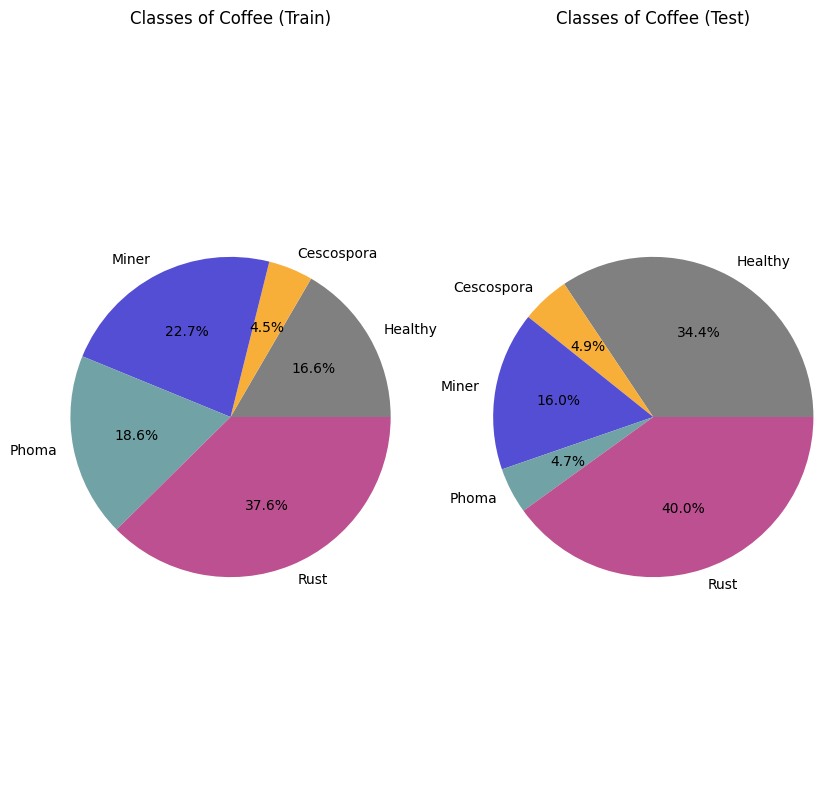

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))
generate_pie_plot(coffeedatadf, 'Classes of Coffee (Train)', ax[0])
generate_pie_plot(coffeetestdatadf, 'Classes of Coffee (Test)', ax[1])

Building a CSV metafile of image info that I will use to load the data later

In [ ]:
#saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR_TRAIN, SINGLE_LEAVES_DATA_DIR_TRAIN, CLASSNAMES, 'coffeediseasedata.csv')
#saveImageDataAndMetaData(SINGLE_LEAVES_DATA_DIR_TEST, SINGLE_LEAVES_DATA_DIR_TEST, CLASSNAMES, 'coffeediseasetestdata.csv')

## Load the Corn Data for Training

In [ ]:
IMAGE_SIZE = 256
META_DATA_FILE = SINGLE_LEAVES_DATA_DIR_TRAIN / 'coffeediseasedata.csv'
batch_size = 32

In [ ]:
coffee_images, coffee_classes, coffee_ids = LoadData(SINGLE_LEAVES_DATA_DIR_TRAIN, IMAGE_SIZE)

4444


Split test data into validation and testing images

In [ ]:
coffee_test_images, coffee_test_classes, coffee_test_ids = LoadData(SINGLE_LEAVES_DATA_DIR_TEST, IMAGE_SIZE)

2300


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
val_images, test_images, val_id, test_id, val_class, test_class = \
train_test_split(coffee_test_images, coffee_test_ids, coffee_test_classes,
                 test_size=0.5, random_state=1234, shuffle=True, stratify=coffee_test_classes)

In [ ]:
train_df = pd.DataFrame(np.array(np.unique(coffee_classes, return_counts=True)).T, columns=['Disease', 'numberImages'])
test_df = pd.DataFrame(np.array(np.unique(test_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
val_df = pd.DataFrame(np.array(np.unique(val_class, return_counts=True)).T, columns=['Disease', 'numberImages'])
train_df['numberImages'] = train_df['numberImages'].astype('int32')
test_df['numberImages'] = test_df['numberImages'].astype('int32')
val_df['numberImages'] = val_df['numberImages'].astype('int32')

Proportion of data in class Cescospora is 200 : 4.50 %
Proportion of data in class Healthy is 738 : 16.61 %
Proportion of data in class Miner is 1009 : 22.70 %
Proportion of data in class Phoma is 826 : 18.59 %
Proportion of data in class Rust is 1671 : 37.60 %
Proportion of data in class Cescospora is 56 : 4.87 %
Proportion of data in class Healthy is 395 : 34.35 %
Proportion of data in class Miner is 184 : 16.00 %
Proportion of data in class Phoma is 54 : 4.70 %
Proportion of data in class Rust is 461 : 40.09 %
Proportion of data in class Cescospora is 56 : 4.87 %
Proportion of data in class Healthy is 396 : 34.43 %
Proportion of data in class Miner is 185 : 16.09 %
Proportion of data in class Phoma is 53 : 4.61 %
Proportion of data in class Rust is 460 : 40.00 %


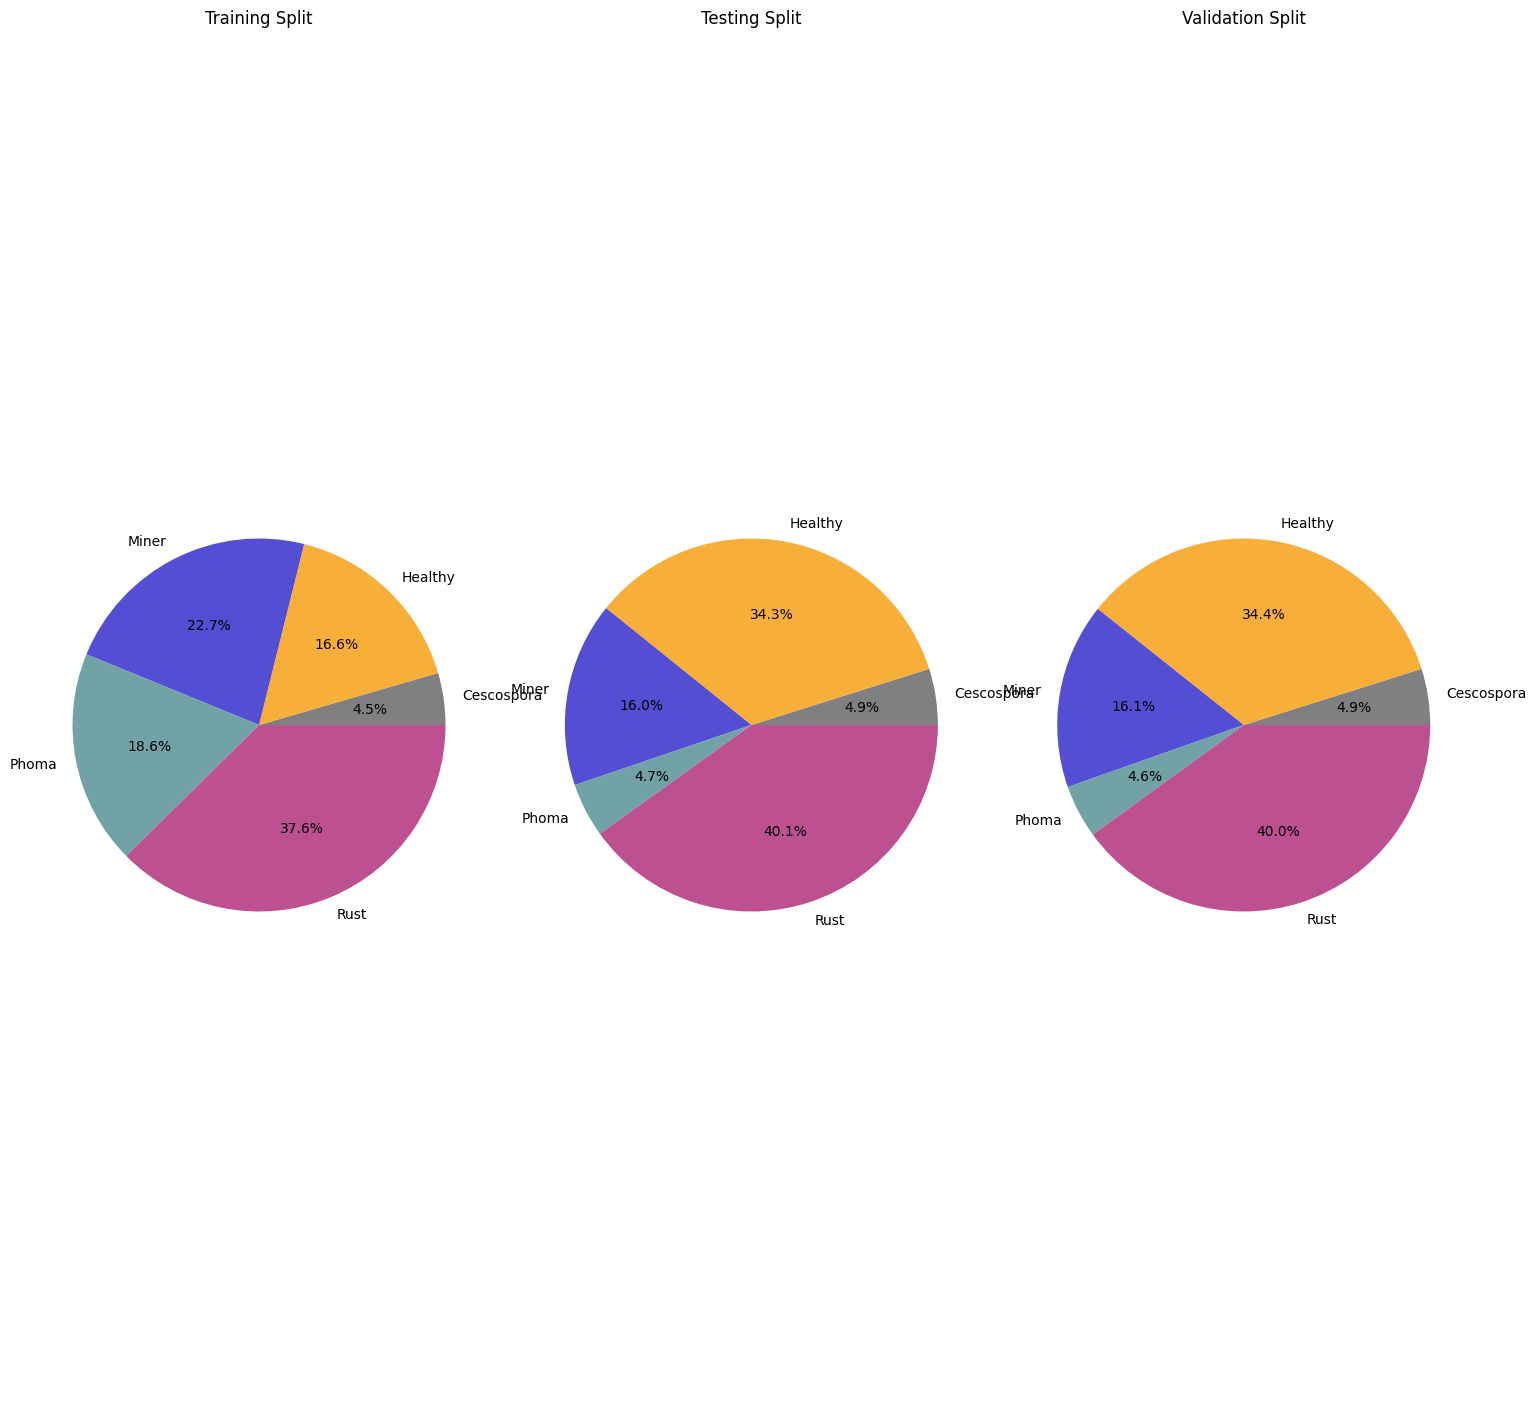

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,18))
generate_pie_plot(train_df, title="Training Split", ax=ax[0])
generate_pie_plot(test_df, title="Testing Split", ax=ax[1])
generate_pie_plot(val_df, title="Validation Split", ax=ax[2])

In [ ]:
import tensorflow as tf

Visualize some sample input images

In [ ]:
def VisualizeSampleImages(image, convert=False):
    ## Note convert from BGR to RGB here
    if convert:
      plt.imshow(image[:,:,::-1])
    else:
      plt.imshow(image)
    #plt.show()

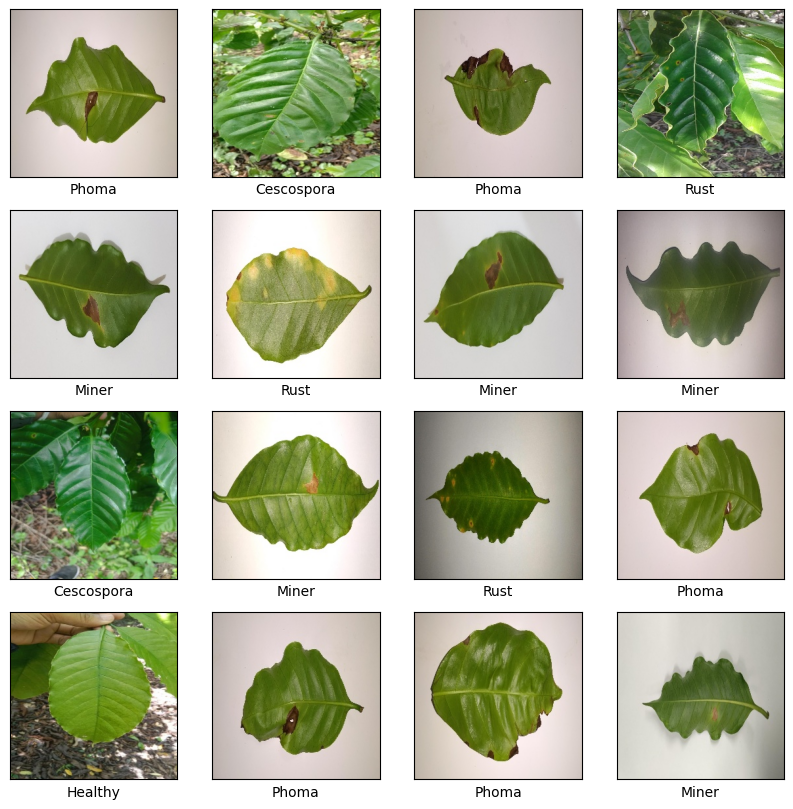

In [ ]:
plt.subplots(4, 4, figsize=(10,10))
num_total = coffee_images.shape[0]
for i, k in enumerate(np.random.randint(num_total, size=16)):
    image = cv2.imread(coffee_images[k])
    plt.subplot(4, 4, i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image, True)
    plt.xlabel(coffee_classes[k])

Adding an alternate mechanism to visualize images using ipyplot

In [ ]:
VisualizeAsClassTabs(META_DATA_FILE, CLASSNAMES, 10)

In [ ]:
VisualizeAsClassTabs(SINGLE_LEAVES_DATA_DIR_TEST/'coffeediseasetestdata.csv', CLASSNAMES, 10)

Make a Tensorflow dataset

In [ ]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []
    pairData = []

    classes = np.unique(labels)
    idx = [np.where(labels == i)[0] for i  in classes]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        #print(f"Current: {currentImage}")

        idxB = np.random.choice(idx[list(classes).index(label)])
        posImage = images[idxB]
        #print(f"Pos Image: {posImage}")

        #pairImages.append([currentImage, posImage])
        #pairLabels.append([1])
        pairData.append((currentImage, posImage, 1))

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        #print(f"Neg Image: {negImage}")

        #pairImages.append([currentImage, negImage])
        #pairLabels.append([0])
        pairData.append((currentImage, negImage, 0))

    return np.asarray(pairData)


In [ ]:
train_pairs = make_pairs(coffee_images.tolist(), coffee_classes)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(train_pairs)
train_ds = train_ds.shuffle(train_df.numberImages.sum(), reshuffle_each_iteration=False)

In [ ]:
val_pairs = make_pairs(val_images.tolist(), val_class)
val_ds = tf.data.Dataset.from_tensor_slices(val_pairs)

In [ ]:
for f in train_ds.take(5):
  print(f.numpy())

[b'/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Miner/cld-kaggle-train-miner (327).jpg'
 b'/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Phoma/cld-kaggle-train-phoma (189).jpg'
 b'0']
[b'/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Healthy/IMG_20221126_114056-576x768_jpg.rf.3610cdc146e1967c16213197da2e1464.jpg'
 b'/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Rust/C10P20H2.jpg'
 b'0']
[b'/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Miner/cld-kaggle-train-miner (297).jpg'
 b'/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/train_opencv_resized/Rust/163.jpg'
 b'0']
[b'/content/drive/MyDrive/Task-3-Data Augmentation/data/002_strategy_just_single_leaves/tra

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

8888
2300


In [ ]:
## Boilerplate
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == CLASSNAMES
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

def process_path(data_bits):
  label_1 = get_label(data_bits[0])
  label_2 = get_label(data_bits[1])
  # Load the raw data from the file as a string
  img_1 = tf.io.read_file(data_bits[0])
  img_1 = decode_img(img_1)
  img_2 = tf.io.read_file(data_bits[1])
  img_2 = decode_img(img_2)
  return (img_1, img_2), int(data_bits[2])

def configure_for_performance(ds):
  #ds = ds.apply(tf.data.experimental.unbatch())
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

tf.Tensor(0, shape=(), dtype=int32)


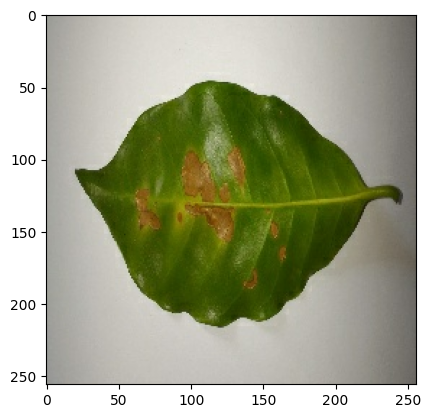

In [ ]:
for f in train_ds.take(1):
  VisualizeSampleImages(f[0][0][16].numpy().astype('uint8'))
  print(f[1][16])

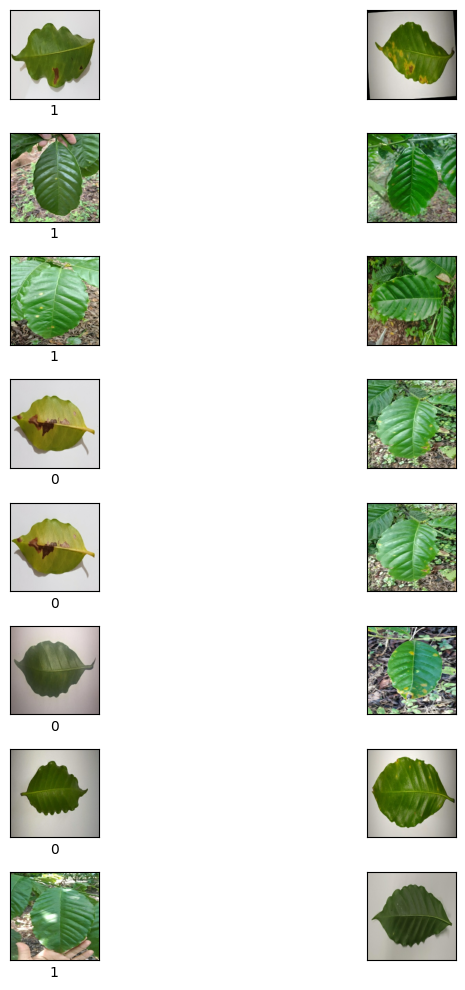

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.subplots(8, 2, figsize=(10,10))
for i, k in enumerate(np.random.randint(batch_size, size=8)):
    plt.subplot(8, 2, 2*i+1)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image_batch[0][k].numpy().astype('uint8'))
    plt.xlabel(f"{label_batch[k].numpy()}")
    plt.subplot(8, 2, 2*i+2)
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    VisualizeSampleImages(image_batch[1][k].numpy().astype('uint8'))
plt.tight_layout()
plt.show()

### Build the Coffee Disease Classification model

In [ ]:
# Models
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten, BatchNormalization, Lambda

In [ ]:
# Callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# Optimizer
from tensorflow.keras.optimizers import Adam

In [ ]:
def build_siamese_model(inputShape, embeddingDim=250, trainBackbone=False):
  backbone = MobileNetV2(input_shape=inputShape,
                         weights='imagenet',
                         include_top=False)
  backbone.trainable = trainBackbone

  MODEL_NAME = 'Coffee_Disease_Siamese_Model'
  #InputLayer
  inputs = Input(shape=inputShape, name="InputLayer")
  # Preprocess Input
  x = mobilenet_v2.preprocess_input(inputs)
  # MobileNetV2 Backbone
  x = backbone(x)
  # Regularization
  x = Dropout(0.3, name="DropOut")(x)
  # FCN
  x = Flatten()(x)
  x = Dense(1024, activation='relu', name="Dense_FCN_1")(x)
  x = BatchNormalization()(x)
  # Outputs
  outputs = Dense(embeddingDim)(x)
  #Model
  model = Model(inputs, outputs, name=MODEL_NAME)
  return model

Train the Siamese Model

In [ ]:
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    (featsA, featsB) = vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)

    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin -preds, 0))
    loss = K.mean(y * squaredPreds + (1-y)*squaredMargin)

    return loss

def plot_training(H, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    #plt.plot(H.history["accuracy"], label="train_acc")
    #plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    #plt.savefig(plotPath)
    plt.show()

In [ ]:
EPOCHS = 10
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [ ]:
def train_siamese_model(epochs, train_ds, val_ds):
  print("[INFO] building siamese network...")
  imgA = Input(shape=IMG_SHAPE)
  imgB = Input(shape=IMG_SHAPE)
  featureExtractor = build_siamese_model(IMG_SHAPE, 256, True)
  featsA = featureExtractor(imgA)
  featsB = featureExtractor(imgB)

  distance = Lambda(euclidean_distance)([featsA, featsB])
  model = Model(inputs=[imgA, imgB], outputs=distance)

  print("[INFO] compiling model...")
  model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=1e-4))

  print("[INFO] training model...")
  history = model.fit(
      train_ds,
      validation_data=val_ds,
      batch_size = batch_size,
      epochs = epochs
  )

  print("[INFO] saving siamese model...")
  #model.save(config.MODEL_PATH)

  print("[INFO] saving Siamese model...")
  plot_training(history, "savefig.png")

In [ ]:
train_siamese_model(EPOCHS, train_ds, val_ds)

[INFO] building siamese network...
[INFO] compiling model...
[INFO] training model...
Epoch 1/10
 57/278 [=====>........................] - ETA: 10:41 - loss: 186.0198

In [ ]:
class ShowProgress(Callback):

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            plt.subplots(1, 2, figsize=(10, 10))
            for image, label in train_ds.take(1):
                pred_kps = self.model.predict(image)
                plt.subplot(1, 2, 1)
                plt.gca().set_yticklabels([])
                plt.gca().set_xticklabels([])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
                VisualizeSampleImages(image[0].numpy().astype("uint8"))
                plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[0]]}/ GT: {CLASSNAMES[label[0]]}")
                #plt.xlabel(f"GT:{input_class[k]}")
            plt.show()

In [ ]:
WEIGHT_DIR = Path('/content/drive/MyDrive/CoffeeCheckpoints')
WEIGHT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
EPOCHS=10
# Compile
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-4),
                metrics=['accuracy']) # Lower the Learning Rate better the results.
checkpoint_path = str(WEIGHT_DIR)+MODEL_NAME+"-{epoch:04d}.ckpt"
# Model Training
callbacks = [
#     EarlyStopping(patience=7, restore_best_weights=True), # keep the patience low.
    ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True),
    ShowProgress()
]
weights = {0:(4444/(4*664)), 1:(4444/(4*180)), 2:(4444/(4*908)), 3:(4444/(4*743)), 4:(4444/(4*1504))}
history = model_1.fit(train_ds,
                      validation_data=val_ds,
                      epochs=EPOCHS,
                      #steps_per_epoch = 125,
                      class_weight=weights,
                      callbacks=callbacks)

In [ ]:
lc = pd.DataFrame(history.history)
lc.plot(figsize=(10,8))
plt.title("Learning Curve", fontsize=25)
plt.grid()
plt.legend(fontsize=12)
plt.show()

### Error Analysis

In [ ]:
from sklearn.metrics import accuracy_score
def Accuracy_ConfusionMatrix(actual, predicted, categories):
    print(f"Accuracy of model: {accuracy_score(actual, predicted)}")
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'])
    print(confusion_matrix)
    print("Sensitivity of model for individual classes")
    class_sum = np.sum(confusion_matrix, axis=1)
    for c,i in enumerate(categories):
        print(f"Class {i} : {confusion_matrix.iloc[c][c]/class_sum[c]}")

In [ ]:
def get_predicted_classes(data_images, model):
    '''
    data_images: shape [None, 112, 112, 3]
    '''
    data_kps = model.predict(data_images)
    return data_kps

In [ ]:
def generateMatrix(dataset):
    ds_labels=[]
    pred_labels=[]
    for images, labels in dataset:
        ds_labels.extend(labels.numpy().tolist()) # or labels.numpy().argmax() for int labels
        precited_train_classes = get_predicted_classes(images, model_1)
        pred_labels.extend(np.argmax(precited_train_classes, axis = 1))
    Accuracy_ConfusionMatrix(ds_labels, pred_labels, CLASSNAMES)
    return ds_labels, pred_labels

In [ ]:
train_true, train_pred = generateMatrix(train_ds)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(train_true, train_pred, target_names=CLASSNAMES))

In [ ]:
val_true, val_pred = generateMatrix(val_ds)

In [ ]:
print(classification_report(val_true, val_pred, target_names=CLASSNAMES))

In [ ]:
plt.subplots(4, 4, figsize=(10, 10))
for image, label in val_ds.take(1):
    pred_kps = model_1.predict(image)
    for i, k in enumerate(np.random.randint(batch_size, size=16)):
      plt.subplot(4, 4, i+1)
      plt.gca().set_yticklabels([])
      plt.gca().set_xticklabels([])
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      VisualizeSampleImages(image[i].numpy().astype("uint8"))
      plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[i]]}/ GT: {CLASSNAMES[label[i]]}")
    #plt.xlabel(f"GT:{input_class[k]}")
plt.show()

## Evaluate from saved model

In [ ]:
checkPathExists(Path(testDirectory).parent/'models/MobileNetV2_weights')

In [ ]:
from tensorflow.train import latest_checkpoint
latest = latest_checkpoint(Path(testDirectory).parent/'models/MobileNetV2_weights')
latest

In [ ]:
from keras.models import Model
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from keras.layers import Input, Dropout, SeparableConv2D, Dense, Flatten, BatchNormalization
# Optimizer
from tensorflow.keras.optimizers import Adam

backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
backbone.trainable = False

MODEL_NAME = 'Coffee_Disease_Classifier'
#InputLayer
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="InputLayer")
# Preprocess Input
x = mobilenet_v2.preprocess_input(inputs)
# MobileNetV2 Backbone
x = backbone(x)
# Regularization
x = Dropout(0.3, name="DropOut")(x)
# FCN
x = Flatten()(x)
x = Dense(1024, activation='relu', name="Dense_FCN_1")(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', name="Dense_FCN_2")(x)
x = Dropout(0.15)(x)
# Outputs
outputs = Dense(5, activation='softmax')(x)

#Model
model_2 = Model(inputs, outputs, name=MODEL_NAME)

# Compile
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-4),
                metrics=['accuracy']) # Lower the Learning Rate better the results.

model_2.load_weights(latest)


In [ ]:
tf.strings.as_string(b'file_path')

In [ ]:
Eval_VAL_ds = tf.data.Dataset.list_files(val_images.tolist(), shuffle=False)
def process_path_mod(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  #img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB )
  img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
  parts = tf.strings.split(file_path, os.path.sep)
  return img, label, parts[-1]
Eval_VAL_ds = Eval_VAL_ds.map(process_path_mod, num_parallel_calls=tf.data.AUTOTUNE)
Eval_VAL_ds = configure_for_performance(Eval_VAL_ds)


In [ ]:
plt.subplots(8, 2, figsize=(20, 20))
i=1
for image, label, file_path in Eval_VAL_ds.take(1):
    pred_kps = model_2.predict(image.numpy().reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3))
    for i, k in enumerate(np.random.randint(batch_size, size=16)):
      plt.subplot(8, 2, i+1)
      plt.gca().set_yticklabels([])
      plt.gca().set_xticklabels([])
      plt.gca().set_xticks([])
      plt.gca().set_yticks([])
      VisualizeSampleImages(image[k].numpy().astype("uint8"))
      plt.xlabel(f"Predicted: {CLASSNAMES[np.argmax(pred_kps, axis=1)[k]]} \n GT: {CLASSNAMES[label[k]]} \n {file_path[k]}")
      #plt.xlabel(f"GT:{input_class[k]}")
      i = i+1
plt.tight_layout()
plt.show()

In [ ]:
im = cv2.imread(str(SINGLE_LEAVES_DATA_DIR_TEST/'Healthy/C5P40H1.jpg'))
im1 = cv2.resize(im, [256, 256])
img = tf.io.read_file(str(SINGLE_LEAVES_DATA_DIR_TEST/'Healthy/C5P40H1.jpg'))
imi = tf.io.decode_jpeg(img, channels=3)
im2 = tf.image.resize(im, [256, 256])


In [ ]:
im_1 = np.reshape(im1, [-1, IMAGE_SIZE, IMAGE_SIZE, 3])

In [ ]:
im_1.shape

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  grad_model = tf.keras.models.Model(
      model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

In [ ]:
pred_kps = model_2.predict(im_1)

In [ ]:
model_2.get_layer("mobilenetv2_1.00_224").output, model_2.output

In [ ]:
gradcamimage = make_gradcam_heatmap(im_1, model_2, "mobilenetv2_1.00_224")

In [ ]:
CLASSNAMES[np.argmax(pred_kps)]

In [ ]:
plt.subplots(1, 3)
plt.subplot(1, 3, 1)
VisualizeSampleImages(im, True)
plt.subplot(1, 3, 2)
VisualizeSampleImages(im1, True)
plt.subplot(1, 3, 3)
VisualizeSampleImages(im2.numpy().astype('uint8'))